https://d2l.ai/chapter_linear-regression/weight-decay.html

We want to limit the complexity of our models, so that we don't run the risk of overfitting.

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


# Weight Decay
To avoid overfitting, the most popular technique of regularization is weight decay. Instead of directly controlling the number of parameters, as this can have a sharp effect on model performance, we will instead try to keep the norm of the weight vector $||w||^2$ as close to 0 as possible. Instead of our previous MSE or $l_1$ loss
$$L(w,b) = \frac{1}{n}\sum_{i=1}^n\frac{1}{2}(w^Tx^i+b-y^i)^2,$$
we want to minimize the sum of the prediction loss and a penalty term based on the weight norm. We do this via a penalty term $L(w,b)+\frac{\lambda}{2}\\w\\^2$ where $\lambda$ is a nonnegative regularization constant. Implemented in our SGD update rule, this becomes:
$$w \leftarrow (1-\eta\lambda)w-\frac{\eta}{|B|}\sum_{i\in B}x^i(w^Tx^i+b-y^i)$$

In [2]:
class Data(d2l.DataModule):# Generate synthetic data
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)


In [3]:
def l2_penalty(w):
    return (w ** 2).sum() / 2
# l2 norm penalty

In [4]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))
# penalty term has now been included in loss function

data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))
# train on 20 examples and evaluate on 100 examples

L2 norm of w: 0.009761182591319084


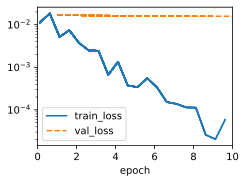

In [5]:
# Train without weight decay, badly overfits
train_scratch(0)

L2 norm of w: 0.0013296481920406222


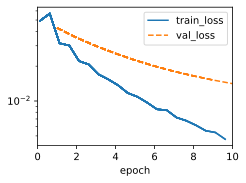

In [11]:
# With weight decay
train_scratch(3)

## Concise Implementation
Implement weight decay using builtin functions.

L2 norm of w: 0.01366215106099844


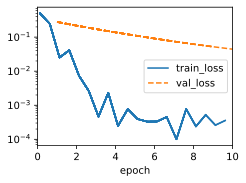

In [13]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd}, #by default torch SGD does weight decay on weights and biases. Here we just do it on the weights
            {'params': self.net.bias}], lr=self.lr)

model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))